In [57]:
import yfinance as yf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [58]:
def get_prices(share_symbol, start_date, end_date, force=False):
    stock_hist = yf.download(share_symbol, start=start_date, end=end_date)
        #stock_hist = share.get_historical(start_date, end_date)
    stock_prices = []
    stock_hist = stock_hist.sort_values(by=['Date'])
    for index, day in stock_hist.iterrows():
        stock_val = day['Open'].astype(float)
        stock_prices.append(stock_val)
        
    stock_prices = np.asarray(stock_prices)
    return stock_prices

In [59]:
prices = get_prices('MSFT', '1992-07-22', '2016-07-22', force=True)
prices = prices.reshape(len(prices),1)
print(prices[:10])
training_set = prices
print(training_set.shape)

[*********************100%%**********************]  1 of 1 completed

[[2.24218798]
 [2.17968798]
 [2.22265601]
 [2.27343798]
 [2.296875  ]
 [2.328125  ]
 [2.296875  ]
 [2.296875  ]
 [2.27343798]
 [2.3125    ]]
(6046, 1)


In [60]:
scaler = MinMaxScaler (feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set

array([[1.63822527e-03],
       [5.46075090e-04],
       [1.29691584e-03],
       ...,
       [9.01007492e-01],
       [9.43645077e-01],
       [9.40674394e-01]])

In [61]:
X_train = []
y_train = []
for i in range (60,len(prices)):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])
X_train = np.array (X_train)
y_train = np.array (y_train)
print(X_train.shape)
print(y_train.shape)

(5986, 60)
(5986,)


In [62]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

(5986, 60, 1)


In [63]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [64]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences= True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences= True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

In [65]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
188/188 [==============================] - 9s 34ms/step - loss: 0.0087
Epoch 2/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0028
Epoch 3/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0027
Epoch 4/30
188/188 [==============================] - 7s 36ms/step - loss: 0.0024
Epoch 5/30
188/188 [==============================] - 7s 36ms/step - loss: 0.0020
Epoch 6/30
188/188 [==============================] - 7s 36ms/step - loss: 0.0020
Epoch 7/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0018
Epoch 8/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0016
Epoch 9/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0014
Epoch 10/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0015
Epoch 11/30
188/188 [==============================] - 7s 36ms/step - loss: 0.0012
Epoch 12/30
188/188 [==============================] - 7s 35ms/step - loss: 0.0014
Epoch 13/30
1

In [66]:
test_prices = get_prices('MSFT', '2017-01-22', '2019-01-22', force=True)
test_prices = test_prices.reshape(len(test_prices),1)

actual_stock_price = test_prices


[*********************100%%**********************]  1 of 1 completed


In [81]:

scaled_testing_set = scaler.transform(test_prices)

print(len(test_prices))
print(len(scaled_testing_set))
print(len(actual_stock_price))

X_test = []
for i in range (60,len(test_prices)):
    X_test.append(scaled_testing_set[i-60:i, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape [1], 1))

502
502
322
(442, 60)


In [82]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = test_prices[60:]

print(len(X_test))
print(len(predicted_stock_price))
print(len(actual_stock_price))

14/14 [==============================] - 0s 9ms/step
442
442
442


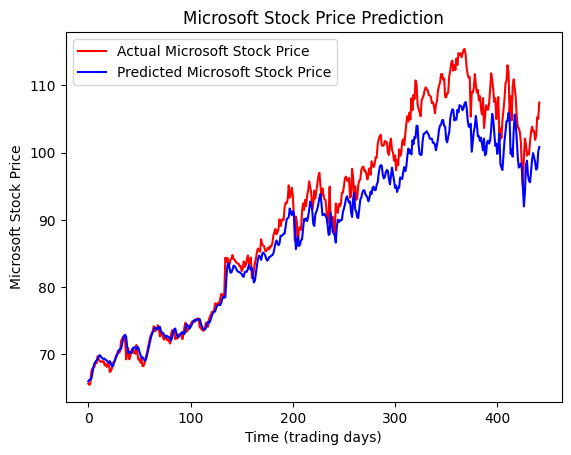

In [110]:
plt.plot(actual_stock_price, color = 'red', label = 'Actual Microsoft Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time (trading days)')
plt.ylabel ('Microsoft Stock Price')
plt.legend ()

In [106]:
def simulation(predicted_price, actual_prices, initial_budget, initial_num_stocks):
    
    budget = initial_budget
    num_stocks = initial_num_stocks
    prev_price = predicted_price[0]
    protfolio = []
    for i in range(1,len(actual_prices)):
        if predicted_price[i] > prev_price:
            if budget >= actual_prices[i-1]:
                #buy a single share of stock
                budget -= actual_prices[i-1]
                num_stocks += 1
            else:
                if budget > 0:
                    num_stocks += budget / actual_prices[i-1]
                    budget = 0
        else:
            if predicted_price[i] < prev_price:
                if num_stocks >= 1:
                    #sell a single share of stock
                    num_stocks -= 1
                    budget += actual_prices[i-1]
                else:
                    #if holding less than one share, sell all
                    budget += num_stocks * actual_prices[i-1]
            #hold if predicting price staying the same
        new_protfolio = budget + num_stocks * actual_prices[i-1]
        #print(new_protfolio)
        protfolio.append(new_protfolio)
        prev_price = predicted_price[i]
    return protfolio




            




            
        
    

In [107]:
protfolio = simulation(predicted_stock_price, actual_stock_price, 100000.0, 0)
print(len(protfolio))
print(protfolio)

441
[array([100000.]), array([99999.80999756]), array([100000.22999573]), array([100005.66001129]), array([100007.34000397]), array([100008.24000549]), array([100008.66000366]), array([100013.98001862]), array([100012.13999176]), array([100021.40998077]), array([100018.10996246]), array([100014.25997925]), array([100012.96000671]), array([100013.59000397]), array([100012.70999908]), array([100013.61997986]), array([100008.58000183]), array([100010.33000183]), array([100007.50999451]), array([100007.96001434]), array([100010.59999847]), array([100003.15000916]), array([100003.55000305]), array([100004.72000122]), array([100006.38000488]), array([100006.83000946]), array([100007.23000336]), array([100011.38001251]), array([100011.31999969]), array([100016.49998474]), array([100014.17997742]), array([100015.98001862]), array([100031.28000641]), array([100034.91002655]), array([100038.9899826]), array([100037.30001831]), array([100030.72000122]), array([99994.44998932]), array([100003.6899

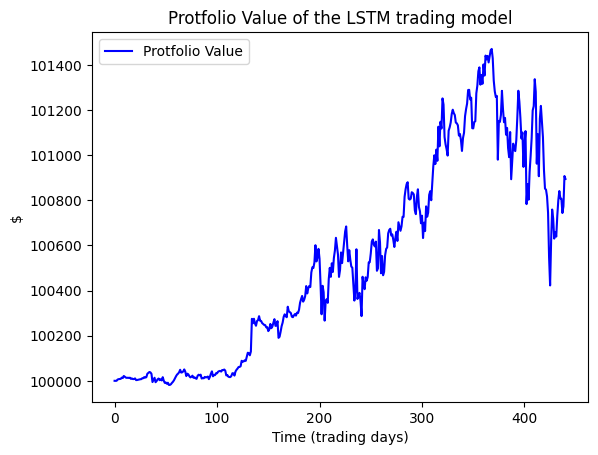

In [111]:
plt.plot(protfolio, color = 'blue', label = 'Protfolio Value')
plt.title('Protfolio Value of the LSTM trading model')
plt.xlabel('Time (trading days)')
plt.ylabel ('$')
plt.legend ()

In [109]:
import json

json_portfolio = [port[0] for port in protfolio]
print(len(json_portfolio))

#dumping protfolio on test set as a json file
with open("LSTM_portfolio.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(json_portfolio, f, indent=2) 


441


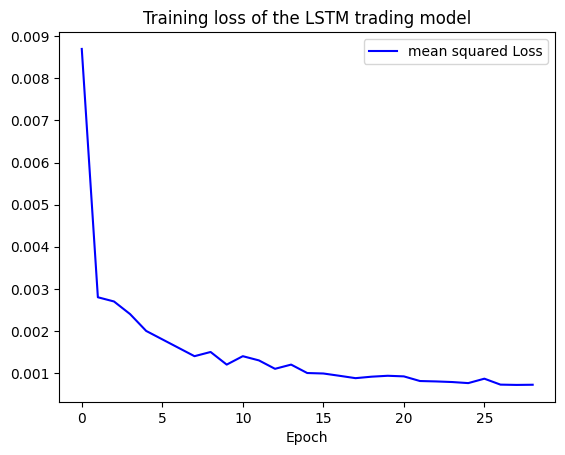

In [113]:
train_loss = [0.0087, 0.0028, 0.0027, 0.0024,0.0020,0.0018, 0.0016, 0.0014, 0.0015, 0.0012, 0.0014,0.0013,0.0011,0.0012, 0.0010, 9.8886e-04,9.3458e-04,8.7790e-04,9.1319e-04,9.3473e-04,9.2039e-04,8.0999e-04,8.0040e-04,7.8593e-04,7.6054e-04,8.6546e-04,7.2438e-04,7.1734e-04,7.2159e-04]
plt.plot(train_loss, color = 'blue', label = 'mean squared Loss')
plt.title('Training loss of the LSTM trading model')
plt.xlabel('Epoch')
plt.legend ()